# 0. Imports and Dataset

In [1]:
from itertools import product
from typing import List

import chex
import jax
from jax import jit, value_and_grad, vmap
import jax.numpy as jnp
import jax.random as jr
from flax.core import freeze, unfreeze
import flax.linen as nn
from flax.training.train_state import TrainState
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from typing import Callable
from tqdm.notebook import tqdm
from jax.flatten_util import ravel_pytree
import torchvision
from torch.utils.data import Dataset, DataLoader
import optax

from jax.scipy.signal import convolve2d
from jax.lax import scan

In [2]:
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True)
images = np.array(mnist_train.data) / 255.0
labels = mnist_train.targets

mnist_test = torchvision.datasets.MNIST(root='./data', train=False)
images_test = np.array(mnist_test.data) / 255.0
labels_test = mnist_test.targets

X_train, y_train = jnp.array(images), jnp.array(labels)
X_test, y_test = jnp.array(images_test), jnp.array(labels_test)

100%|██████████| 9912422/9912422 [00:00<00:00, 172533370.04it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 86217575.68it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 64101913.97it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 15941865.08it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# 1. Mask Generation

## 1.1 Example

We show an example of applying the mask-generation pipeline described in the paper.

In [3]:
key = jr.PRNGKey(0)
mask_example = jr.randint(key, (28, 28), minval=0, maxval=2).astype(float)

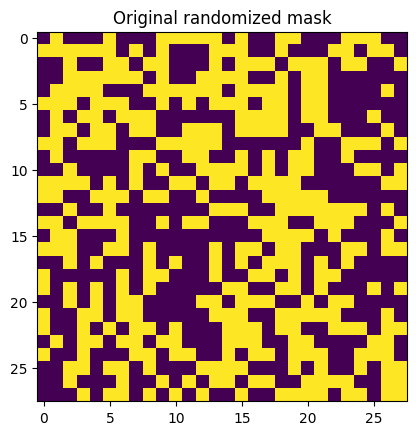

In [4]:
fig, ax = plt.subplots()
ax.imshow(mask_example);
ax.set_title('Original randomized mask');

In [5]:
def blur_filter(image, filter=(1/4, 1/2, 1/4), n_iter=5):
    filter = jnp.array(filter)

    def _apply_filter(image, _):
        # Horizontal filter
        blurred_image = convolve2d(image, filter.reshape(-1, 1), mode='same')

        # Vertical filter
        blurred_image = convolve2d(blurred_image, filter.reshape(1, -1), mode='same')

        return (blurred_image), (blurred_image)
    
    blurred_image, _ = scan(_apply_filter, image, jnp.arange(n_iter))

    return blurred_image

apply_threshold = lambda arr: jnp.where(arr >= 0.5, 1.0, 0.0)

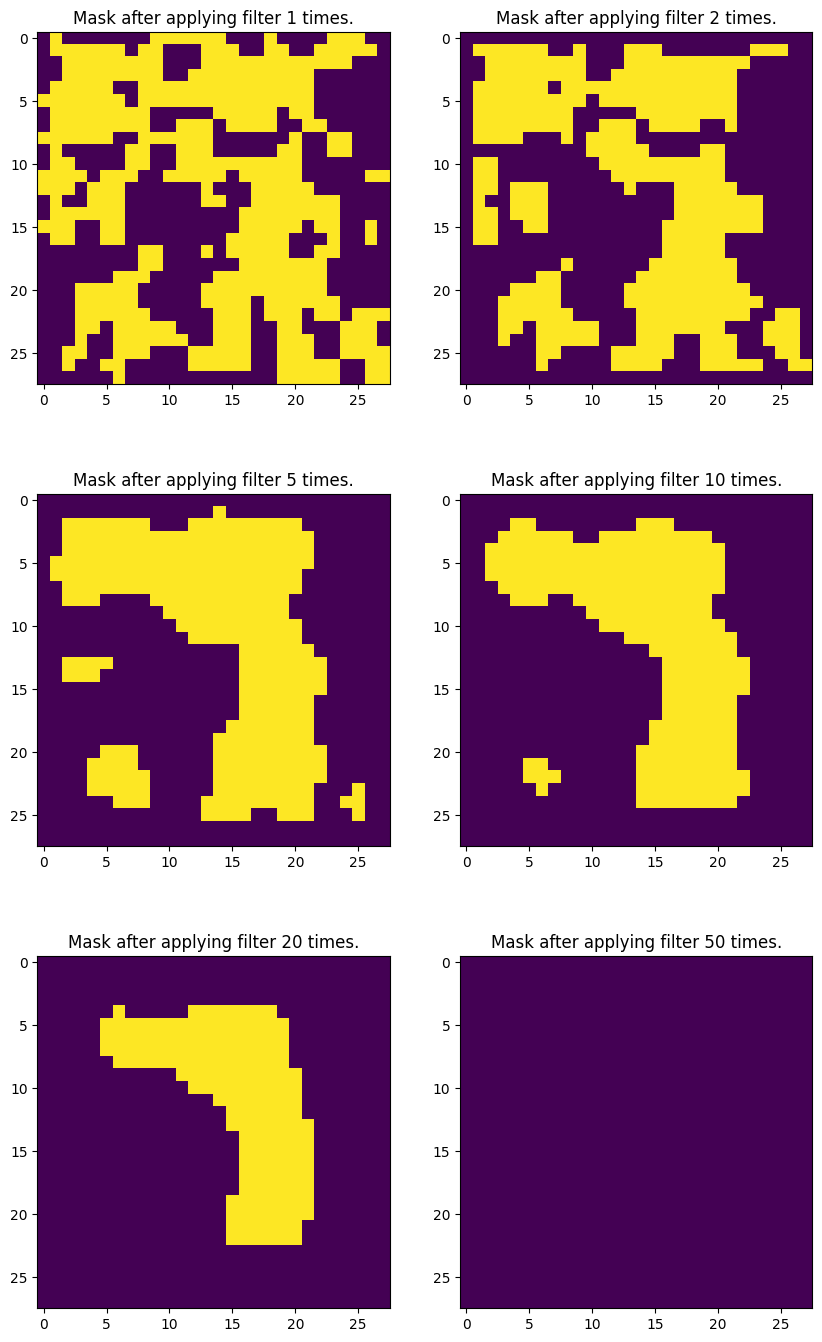

In [6]:
fig, axes = plt.subplots(3, 2, figsize=(10, 17))
n_iter_list = (1, 2, 5, 10, 20, 50)

for i, n_iter in enumerate(n_iter_list):
    curr_ax = axes[i//2, i%2]
    blurred_image = apply_threshold(blur_filter(mask_example, n_iter=n_iter))
    curr_ax.imshow(blurred_image)
    curr_ax.set_title(f'Mask after applying filter {n_iter} times.');

Using this mask (after applying filter 5 times) we can generate a hybrid image used as negative data.

In [7]:
blurred_image = apply_threshold(blur_filter(mask_example, n_iter=5))
neg_blurred_image = 1-blurred_image

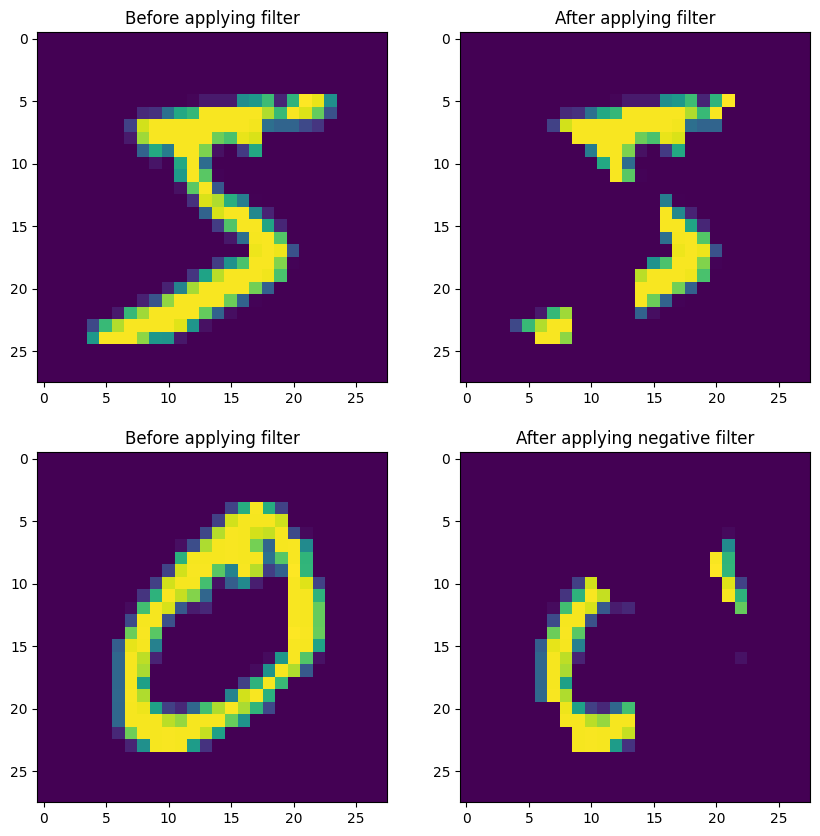

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0,0].imshow(images[0]);
axes[0,0].set_title('Before applying filter');
axes[1,0].imshow(images[1]);
axes[1,0].set_title('Before applying filter');

axes[0,1].imshow(images[0]*blurred_image);
axes[0,1].set_title('After applying filter');
axes[1,1].imshow(images[1]*neg_blurred_image);
axes[1,1].set_title('After applying negative filter');

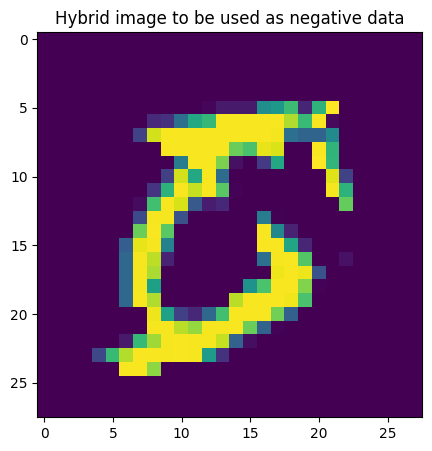

In [9]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(images[0]*blurred_image + images[1]*neg_blurred_image);
ax.set_title('Hybrid image to be used as negative data');

## 1.2 Generating Negative Data

In [10]:
def generate_negative_mnist_data(X_train, y_train, n_data=60_000, key=42):
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    def _generate(_, key):
        keys = jr.split(key, 4)

        # Randomly sample a pair of digits (w/o replacement)
        d1, d2 = jr.choice(keys[0], jnp.arange(10), (2,), replace=False)
        ims1, ims2 = X_train[y_train], X_train[y_train]

        # Randomly sample images from the chosen digits
        indx1, indx2 = jr.choice(keys[1], ims1.shape[0]), jr.choice(keys[2], ims2.shape[0])
        im1, im2 = ims1[indx1], ims2[indx2]

        # Apply filter
        mask = jr.randint(keys[3], (28, 28), minval=0, maxval=2).astype(float)
        mask = apply_threshold(blur_filter(mask, n_iter=5))
        neg_im = im1*mask + im2*(1-mask)

        return neg_im, neg_im
    
    keys = jr.split(key, n_data)
    carry = jnp.ones((28,28)).astype(float)

    _, neg_ims = scan(_generate, carry, keys)

    return neg_ims


In [11]:
neg_ims = generate_negative_mnist_data(X_train, y_train)

Example of a negative data that's been generated:

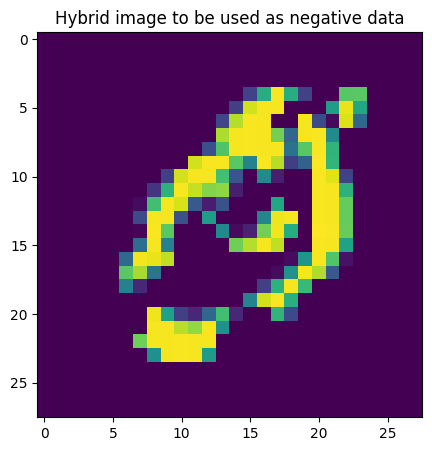

In [12]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(neg_ims[0]);
ax.set_title('Hybrid image to be used as negative data');

In [13]:
# Generic MNIST Dataset
class MNISTDataset(Dataset):
    def __init__(self, images, labels):
        assert len(images) == len(labels)
        self.images = images
        self.labels = labels
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

    def __len__(self):
        return len(self.images)

In [14]:
# Train dataloaders
pos_train_loader = DataLoader(
    MNISTDataset(np.array(X_train), np.ones(len(X_train))),
    batch_size = 64,
    shuffle = True,
)
neg_train_loader = DataLoader(
    MNISTDataset(np.array(neg_ims), np.zeros(len(neg_ims))),
    batch_size=64,
    shuffle=True
)
mixed_train_loader = DataLoader(
    MNISTDataset(
        np.concatenate([X_train, neg_ims], axis=0),
        np.concatenate([np.ones(len(X_train)), np.zeros(len(neg_ims))], axis=0)
    ),
    batch_size=64,
    shuffle=True
)

# 2. FFA Layers

In [15]:
class SimpleLayerNorm(nn.Module):
    epsilon: float = 1e-8

    @nn.compact
    def __call__(self, x):
        norm = jnp.linalg.norm(x) + self.epsilon

        return x / norm

In [16]:
class FFLayer(nn.Module):
    n_units: int = 2_000
    activation: Callable = nn.relu

    @nn.compact
    def __call__(self, x):
        x = SimpleLayerNorm()(x)
        x = nn.Dense(self.n_units)(x)
        x = self.activation(x)
        return x

In [17]:
class FFLayers(nn.Module):
    n_layers: int = 4
    n_units: int = 2_000
    activation: Callable = nn.relu

    def setup(self):
        self.layers = [
            FFLayer(self.n_units, self.activation) for _ in range(self.n_layers)
        ]

    def __call__(self, x, layer_idx=None):
        x = x.ravel()
        if layer_idx is not None:
            assert layer_idx >= 0 and layer_idx < self.n_layers
            x = self.layers[layer_idx](x)
        else:
            for layer in self.layers:
                x = layer(x)
    
        return x

In [18]:
# Initialize FFLayer model
model = FFLayers()
params = model.init(jr.PRNGKey(0), X_train[0])
flat_params, unflatten_fn = ravel_pytree(params)

# Apply each layer individually
first_layer_output = model.apply(params, X_train[0], layer_idx=0)
second_layer_output = model.apply(params, first_layer_output, layer_idx=1)
third_layer_output = model.apply(params, second_layer_output, layer_idx=2)
final_layer_output = model.apply(params, third_layer_output, layer_idx=3)

# Apply all layer
output = model.apply(params, X_train[0])

assert jnp.allclose(final_layer_output, output)

In [106]:
def create_train_state(X, params=None, layer_idx=None, lr=1e-3, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    model = FFLayers()
    if params is None:
        params = model.init(key, jnp.array(X))['params']
    opt = optax.adam(learning_rate=lr)
    apply_fn = lambda p, x: model.apply({"params": p}, x, layer_idx=layer_idx)
    train_state = TrainState.create(apply_fn=apply_fn, params=params, tx=opt)

    return train_state

# 3. Unsupervised Example

In [20]:
model = FFLayers()
trainable_params = model.init(jr.PRNGKey(0), X_train[0])
layers = trainable_params["params"]
n_epochs = 1

In [21]:
@jit
def unsup_train_step(train_state, batch_images, batch_labels, threshold=2.0):
    def loss_fn(params):
        activation = vmap(train_state.apply_fn, (None, 0))(params, batch_images)
        logits = vmap(jnp.sum)(jnp.square(activation)).ravel() - threshold
        loss = jnp.mean(optax.sigmoid_binary_cross_entropy(logits, batch_labels.ravel()))

        return loss, logits
    
    (loss, logits), grads = value_and_grad(loss_fn, has_aux=True)(train_state.params)
    accuracy = jnp.mean((logits >= 0.0) == batch_labels)

    return grads, accuracy

In [22]:
# Train each layer, starting from the first layer
prev_params = None
train_states = []

for i, _ in enumerate(layers):
    train_state = create_train_state(X_train[0], prev_params, i)

    for epoch in range(n_epochs):
        accs = []
        pbar = tqdm(enumerate(mixed_train_loader), total=len(mixed_train_loader),
                    desc = f"Layer {i}/{len(layers)}: Epoch {epoch}/{n_epochs}: Average Accauracy: 0.0")
        for k, (batch_images, batch_labels) in pbar:
            batch_images, batch_labels = jnp.array(batch_images), jnp.array(batch_labels)
            output = batch_images
            for prev_state in train_states:
                # Pass through previous (trained) layers
                output = vmap(prev_state.apply_fn, (None, 0))(prev_state.params, output)
            updates, accuracy = unsup_train_step(train_state, output, batch_labels)
            accs.append(accuracy)
            train_state = train_state.apply_gradients(grads=updates)

            if k % 100 == 0:
                pbar.set_description(f"Layer {i}/{len(layers)}: Epoch {epoch}/{n_epochs}: Average Accauracy: {jnp.mean(jnp.array(accs))}")
    prev_params = train_state.params
    train_states.append(train_state)

Layer 0/4: Epoch 1/1: Average Accauracy: 0.0:   0%|          | 0/1875 [00:00<?, ?it/s]

Layer 1/4: Epoch 1/1: Average Accauracy: 0.0:   0%|          | 0/1875 [00:00<?, ?it/s]

Layer 2/4: Epoch 1/1: Average Accauracy: 0.0:   0%|          | 0/1875 [00:00<?, ?it/s]

Layer 3/4: Epoch 1/1: Average Accauracy: 0.0:   0%|          | 0/1875 [00:00<?, ?it/s]

In [102]:
# Test to make sure the training worked on all layers
img, lbl = next(iter(mixed_train_loader))
img, lbl = jnp.array(img), jnp.array(lbl)

st = train_states[-1]

model = FFLayers()
def apply_fn(p, x, i):
    for j in range(i+1):
        x = model.apply({"params": p}, x, layer_idx=j)
    
    return x

threshold = 2.0
for i in range(4):
    activation = vmap(apply_fn, (None, 0, None))(st.params, img, i)
    logits = vmap(jnp.sum)(jnp.square(activation)).ravel() - threshold
    y_preds = (logits > 0).astype(float)

    assert (y_preds - lbl).mean() < 0.05

In [103]:
# Function to generate inputs to linear classifier
def transform_input(x, train_state):
    transformed_input = []
    for i in range(1, len(train_state.params)):
        activation = apply_fn(train_state.params, x, i)
        transformed_input.append(activation)
    transformed_input = jnp.array(transformed_input).ravel()

    return transformed_input

In [104]:
# Transform train and test sets
X_tr_train, X_tr_test = \
    vmap(transform_input, (0, None))(X_train, st), vmap(transform_input, (0, None))(X_test, st)

In [135]:
tr_train_loader = DataLoader(
    MNISTDataset(np.array(X_tr_train), np.array(y_train)),
    batch_size = 64,
    shuffle = True,
)

In [112]:
# Final layer of linear classifier
class LinearClassifier(nn.Module):
    n_outputs: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_outputs)(x)

        return x

In [129]:
# Supervised learning training
def create_lin_clf_train_state(X, n_outputs=10, lr=1e-3, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    clf = LinearClassifier(n_outputs)
    params = clf.init(key, jnp.array(X))
    opt = optax.adam(learning_rate=lr)
    train_state = TrainState.create(apply_fn=clf.apply, params=params, tx=opt)

    return train_state

In [139]:
@jit
def clf_train_step(train_state, batch_images, batch_labels):
    def loss_fn(params):
        logits = vmap(train_state.apply_fn, (None, 0))(params, batch_images)
        loss = jnp.mean(optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=batch_labels))

        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(train_state.params)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == batch_labels)
    
    return grads, accuracy

In [140]:
n_epochs = 1
clf_state = create_lin_clf_train_state(X_tr_train[0])

for epoch in range(n_epochs):
    accs = []
    pbar = tqdm(enumerate(tr_train_loader), total=len(tr_train_loader),
                desc = f"Epoch {epoch}/{n_epochs}: Average Accuracy: 0.0")
    for j, (batch_images, batch_labels) in pbar:
        batch_images, batch_labels = jnp.array(batch_images), jnp.array(batch_labels)
        updates, accuracy = clf_train_step(clf_state, batch_images, batch_labels)
        accs.append(accuracy)
        clf_state = clf_state.apply_gradients(grads=updates)

        if j % 100 == 0:
            pbar.set_description(f"Epoch {epoch}/{n_epochs}: Average Accauracy: {jnp.mean(jnp.array(accs))}")

Epoch 0/1: Average Accuracy: 0.0:   0%|          | 0/938 [00:00<?, ?it/s]

In [151]:
# Evaluate
logits = vmap(clf_state.apply_fn, (None, 0))(clf_state.params, X_tr_test)
y_preds = jnp.argmax(logits, -1)

test_miscl = jnp.mean(y_test != y_preds)
print(f"Test set misclassification rate: {test_miscl}")

Test set misclassification rate: 0.5206999778747559
